As Illumina sequencing becoming more and [more popular](https://ark-invest.com/wp-content/uploads/2014/08/GenBankNumbers-e1408037368293.png), there are various sequencing centers available for sequencing services. Here at UT-Austin, we have a renowned sequencing center ([UT-Austin GSAF](https://sites.cns.utexas.edu/cbrs/genomics/services/next-gen-sequencing)) that has been greatly helpful to my work. However, recently we have had good experience with [MD Anderson Science Park Next-Generation Sequencing (NGS) Facility](https://www.mdanderson.org/research/research-resources/core-facilities/next-generation-sequencing-core.html). So in this post, I am going to compare the sequencing price between these two centers for future reference.

Since the two sequencing centers have their sequencing prices posted online, I will do some web scraping and data cleaning to visualize the comparisons.

In [263]:
%matplotlib inline

import urllib.request
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sequencing_tools.viz_tools import okabeito_palette

# Science park price table #

For MD Anderson Science park price, I will download the data from their [website](https://www.mdanderson.org/research/research-resources/core-facilities/next-generation-sequencing-core/services.html).

In [264]:
mda = 'https://www.mdanderson.org/research/research-resources/core-facilities/next-generation-sequencing-core/services.html'
mda_html = urllib.request.urlopen(mda)
soup = BeautifulSoup(mda_html, 'lxml')
tabs = soup.find_all('table')
table = tabs[-1]
mda_df = pd.read_html(str(table), 
                      flavor='bs4',
                     header=0,
                     index_col = 0)[0]
mda_df

,NGS User Group Member Price (per lane),"MDACC Faculty, UT System, BCM w/ MOU Price (per lane)",*External Out-of-Network Price (per lane)
Service,,,
HiSeq 3000,NaN,NaN,NaN
"50 bp, single read",$966.41,"$1,100.71","$2,177.47"
"75 bp, paired end","$1,746.41","$1,880.71","$3,425.47"
"100 bp, paired end","$2,089.61","$2,223.91","$3,974.59"
"150 bp, paired end","$2,431.25","$2,565.55","$4,521.22"
NextSeq 500,NaN,NaN,NaN
High Output:,NaN,NaN,NaN
"75 bp, single read","$1,632.95","$1,853.96","$3,238.11"
"75 bp, paired end","$3,085.83","$3,306.84","$5,562.72"


Now, I need to clean up the table to make it more easily to manipulate. I will need a function to assign the platform (sequencing machines) for each run type (X bp, paired|single end). Then, I will only look at the member price, since that's what we pay for.

In [265]:
def clean_mda_index(idx, data_col):
    platform = ''
    clear = False
    new_idx = []
    for i, dc in zip(idx,data_col):
        if pd.isnull(dc):
            if clear:
                platform = ''
                clear=False
            platform = platform + i + '_'
            new_idx.append(platform)
        else:
            new_idx.append(platform + i)
            clear = True
    return new_idx

In [266]:
mda_price_df = mda_df \
    .assign(seq_type = lambda d: clean_mda_index(d.index, d.iloc[:,0])) \
    .assign(seq_type = lambda d: np.where(d.seq_type.str.contains('Mid Output'),
                                         'NextSeq 500_' + d.seq_type,
                                         d.seq_type))\
    .reset_index() \
    .drop('Service', axis=1) \
    .pipe(lambda d: d[~pd.isnull(d.iloc[:,1])]) \
    .assign(platform = lambda d: d.seq_type.str.split('_', expand=True).iloc[:,0]) \
    .assign(basepair = lambda d: d.seq_type.str.extract('_([0-9]+)', expand=False).astype(int)) \
    .assign(ends = lambda d: d.seq_type.str.extract('(single|paired)', expand=False)) \
    .pipe(lambda d: d[~d.seq_type.str.contains('Mid')]) \
    .assign(md_price = lambda d: d.iloc[:,0].str.replace('[,$]','').astype(float))\
    .assign(machine = lambda d: d.platform.str.replace(' [0-9]+','')) \
    .assign(total_base = lambda d: np.where(d.ends == "paired", d.basepair * 2, d.basepair))\
    .assign(ends = lambda d: np.where(d.machine=="MiSeq", 'single', d.ends))\
    .filter(regex = 'platform|total|ends|md_price|machine')  \
    .drop_duplicates()
mda_price_df

,platform,ends,md_price,machine,total_base
1,HiSeq 3000,single,966.41,HiSeq,50
2,HiSeq 3000,paired,1746.41,HiSeq,150
3,HiSeq 3000,paired,2089.61,HiSeq,200
4,HiSeq 3000,paired,2431.25,HiSeq,300
7,NextSeq 500,single,1632.95,NextSeq,75
8,NextSeq 500,paired,3085.83,NextSeq,150
9,NextSeq 500,paired,4904.79,NextSeq,300
14,MiSeq,single,948.99,MiSeq,50
15,MiSeq,single,1202.19,MiSeq,300
17,MiSeq,single,1782.99,MiSeq,600


# UT GSAF price table#

For UT GSAF price, we will download the table from [UT GSAF website](https://wikis.utexas.edu/display/GSAF/Library+Prep+and+NGS+Pricing+Descriptions).

In [267]:
gsaf = 'https://wikis.utexas.edu/display/GSAF/Library+Prep+and+NGS+Pricing+Descriptions'
gsaf_html = urllib.request.urlopen(gsaf)
soup = BeautifulSoup(gsaf_html, 'lxml')
tabs = soup.find_all('table')
gsaf_df = pd.read_html(tabs[0].prettify(), 
             flavor='bs4',
             index_col = None,
            header=0)[0] 
gsaf_df

,Platform,Run Type,Internal / UT,External Academic,External Commercial
0,HiSeq 2500,SR 50,$1052,$1331,$1357
1,HiSeq 2500,SR 100,$1428,$1806,$1842
2,HiSeq 2500,PE 125,$2520,$3187,$3250
3,HiSeq 4000,SR 50 (1),"$ 1,043","$ 1,319","$1,345"
4,HiSeq 4000,PE 150 (1),"$ 2,562","$ 3,239","$ 3,266"
5,HiSeq 4000,SR 50,"$ 1,697","$ 2,146","$ 2,173"
6,HiSeq 4000,PE 75,"$ 14,494","$ 18,327","$ 18,531"
7,NextSeq 500,"SR 75 H.O (1,3)","$ 2,302","$ 2,906","$ 3,060"
8,NextSeq 500,"PE 75 H.O . (1,3)","$ 3,826","$ 4,834","$ 4,988"
9,NextSeq 500,PE 150 H.O.,"$ 5,735","$ 7,250","$ 7,404"


The resulting table is much more easy to be interpreted, since it is in a clean format. Again, I will only look at the Internal price.

In [268]:
gsaf_price_df = gsaf_df\
    .iloc[:, :3] \
    .assign(machine = lambda d: d.Platform.str.replace(' [0-9]+','')) \
    .assign(basepair = lambda d: d['Run Type'].str.extract(' ([0-9]+)', expand=False).astype(int)) \
    .assign(ends = lambda d: np.where(d['Run Type'].str.contains('PE'), 'paired', 'single')) \
    .assign(total_base = lambda d: np.where(d.ends == "paired", 
                                      d.basepair * 2, 
                                      d.basepair))\
    .assign(gsaf_price = lambda d: d['Internal / UT'].str.replace('[$.,]','').astype(float)) \
    .filter(regex = 'total|price|machine|ends|Platform')
gsaf_price_df

,Platform,machine,ends,total_base,gsaf_price
0,HiSeq 2500,HiSeq,single,50,1052.0
1,HiSeq 2500,HiSeq,single,100,1428.0
2,HiSeq 2500,HiSeq,paired,250,2520.0
3,HiSeq 4000,HiSeq,single,50,1043.0
4,HiSeq 4000,HiSeq,paired,300,2562.0
5,HiSeq 4000,HiSeq,single,50,1697.0
6,HiSeq 4000,HiSeq,paired,150,14494.0
7,NextSeq 500,NextSeq,single,75,2302.0
8,NextSeq 500,NextSeq,paired,150,3826.0
9,NextSeq 500,NextSeq,paired,300,5735.0


I notice there's duplicate of HiSeq 4000 single end 50-nt price (1043 USD vs 1697.0 USD), so I will take the lowest price, and merge with the science park price.

In [269]:
merge_df = gsaf_price_df\
    .groupby(['Platform','machine','ends','total_base'], as_index=False)\
    .agg({'gsaf_price':np.min})\
    .merge(mda_price_df, how ='outer')
merge_df

,Platform,machine,ends,total_base,gsaf_price,platform,md_price
0,HiSeq 2500,HiSeq,paired,250,2520.0,NaN,NaN
1,HiSeq 2500,HiSeq,single,50,1052.0,HiSeq 3000,966.41
2,HiSeq 4000,HiSeq,single,50,1043.0,HiSeq 3000,966.41
3,HiSeq 2500,HiSeq,single,100,1428.0,NaN,NaN
4,HiSeq 4000,HiSeq,paired,150,14494.0,HiSeq 3000,1746.41
5,HiSeq 4000,HiSeq,paired,300,2562.0,HiSeq 3000,2431.25
6,MiSeq,MiSeq,single,150,1463.0,NaN,NaN
7,MiSeq,MiSeq,single,300,1627.0,MiSeq,1202.19
8,MiSeq,MiSeq,single,500,1771.0,NaN,NaN
9,MiSeq,MiSeq,single,600,2183.0,MiSeq,1782.99


Let's see if prices from both centers are correlated.

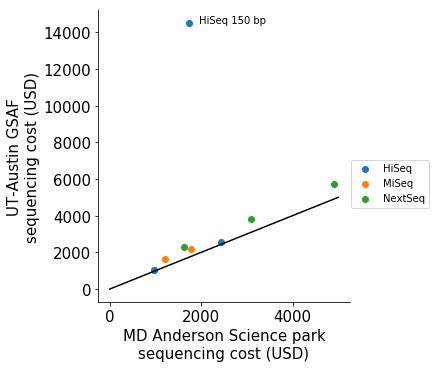

In [270]:
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes',labelsize=15)
p = sns.FacetGrid(data = merge_df,
             hue = 'machine',
             size = 5)
p.map(plt.scatter, 'md_price','gsaf_price')
p.add_legend(title = '')
p.set(xlabel = 'MD Anderson Science park\nsequencing cost (USD)',
     ylabel = 'UT-Austin GSAF\nsequencing cost (USD)')

# label outlier
for i, row in merge_df.iterrows():
    if row['gsaf_price'] > 10000:
        label = row['machine'] + ' ' + str(row['total_base']) + ' bp'
        p.fig.axes[0].text(row['md_price'] + 200,
                           row['gsaf_price'],
                           label)

p.fig.axes[0].plot(range(5000), color = 'black')

We can see that sequencing prices from the both centers are proportion to each other, with NextSeq runs tend to be of higher costs.

There is an HiSeq run being an outlier in the plot (~14000 USD at UT-Austin GSAF vs ~2000 USD at MDA Smithville), it is possibly mis-labeled of a full run (8 lanes for HiSeq) price instead of a per-lane-price. For the next analysis, I will assume that's the case.

I am interested at the head-to-head comparisons between the two sequencing centers for different sequencing run types,

/Users/wckdouglas/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(0,0.8,'Per-lane-price (USD)')

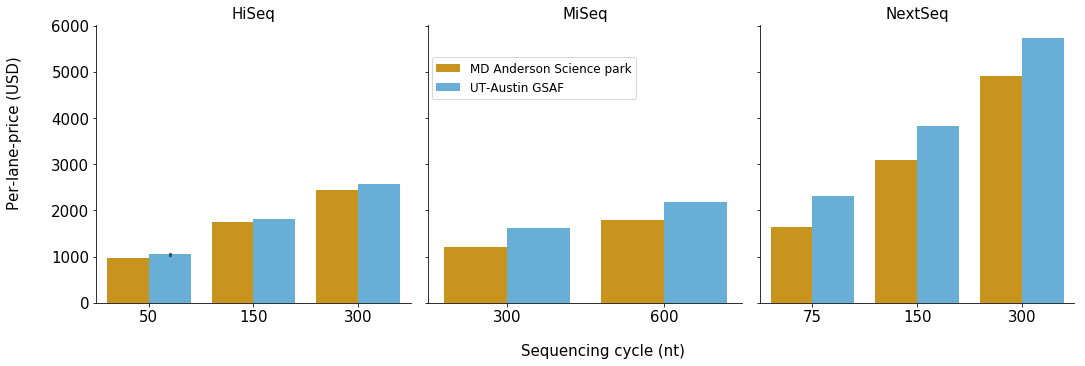

In [271]:
merge_df = gsaf_price_df\
    .groupby(['Platform','machine','ends','total_base'], as_index=False)\
    .agg({'gsaf_price':np.min})\
    .merge(mda_price_df, how ='inner') \
    .filter(regex = 'price|machine|ends|base')\
    .pipe(pd.melt, id_vars = ['machine','ends','total_base'],
                 var_name = 'center',
                 value_name = 'price')\
    .assign(center = lambda d: np.where(d['center'].str.contains('gsaf'),
                                        'UT-Austin GSAF',
                                        'MD Anderson Science park')) \
    .assign(price = lambda d: np.where(d.price > 10000, d.price / 8, d.price))

p = sns.FacetGrid(data = merge_df,
             col = 'machine',
             sharex=False,
             size = 5)
p.map(sns.barplot, 'total_base',
                  'price',
                  'center',
                  palette = okabeito_palette(),
                  hue_order = ['MD Anderson Science park',
                              'UT-Austin GSAF'])
p.add_legend(bbox_to_anchor=(0.5,0.8),
            fontsize=12)
p.set(xlabel = '',
     ylabel = '')
p.set_titles('{col_name}')
p.fig.text(0.4, 0, 'Sequencing cycle (nt)', fontsize = 15)
p.fig.text(0, 0.8, 'Per-lane-price (USD)', fontsize = 15, rotation=90)

So it looks like that UT Austin GSAF has a higher price for every sequencing type. 

For the comparison in HiSeq runs, GSAF is running HiSeq 4000 while MD Anderson Science Park is running HiSeq 3000, so that maybe one of the reason. For the other ones, seems like the machines are the same.